In [ ]:
!pip install -r requirements.txt
!pip install -U ultralytics
!yolo checks
import json
import random
import shutil
from pathlib import Path
from PIL import Image
import yaml
from ultralytics import YOLO





Ultralytics 8.4.9  Python-3.12.7 torch-2.9.1+cpu CPU (12th Gen Intel Core i7-1255U)
Setup complete  (12 CPUs, 15.7 GB RAM, 443.4/474.7 GB disk)

OS                     Windows-11-10.0.26200-SP0
Environment            Windows
Python                 3.12.7
Install                pip
Path                   C:\Users\owner\anaconda3\Lib\site-packages\ultralytics
RAM                    15.73 GB
Disk                   443.4/474.7 GB
CPU                    12th Gen Intel Core i7-1255U
CPU count              12
GPU                    None
GPU count              None
CUDA                   None

numpy                   1.26.4>=1.23.0
matplotlib              3.10.8>=3.3.0
opencv-python           4.10.0>=4.6.0
pillow                  12.1.0>=7.1.2
pyyaml                  6.0.1>=5.3.1
requests                2.32.3>=2.23.0
scipy                   1.13.1>=1.4.1
torch                   2.9.1>=1.8.0
torch                   2.9.1!=2.4.0,>=1.8.0; sys_platform == "win32"
torchvision             0.24.1>

Converting COCO to YOLO

In [ ]:
randomSeed = 42
random.seed(randomSeed)

lsJsonPath = Path("signs.json")
imagesDir = Path("signs_coco/images")

outputDir = Path("datasets/yoloMountingType")
labelsDir = outputDir / "labels"
splitDir = outputDir / "images"

classNames = ["Pole-mounted", "Wall-mounted"]
nameToClassIndex = {name: i for i, name in enumerate(classNames)}

# Load Label Studio tasks
data = json.loads(lsJsonPath.read_text(encoding="utf-8"))

# Clean rebuild (removes old empty labels)
if outputDir.exists():
    shutil.rmtree(outputDir)

for splitName in ["train", "val", "test"]:
    (labelsDir / splitName).mkdir(parents=True, exist_ok=True)
    (splitDir / splitName).mkdir(parents=True, exist_ok=True)

def getImageFileName(task):
    imageValue = task.get("data", {}).get("image")
    return Path(str(imageValue)).name if imageValue else None

def getResults(task):
    return task["annotations"][-1]["result"]  # your export has this

def rectPercentToPixelBBox(value, imgW, imgH):
    x = (value["x"] / 100.0) * imgW
    y = (value["y"] / 100.0) * imgH
    w = (value["width"] / 100.0) * imgW
    h = (value["height"] / 100.0) * imgH
    return x, y, w, h

tasks = []
for task in data:
    imageFileName = getImageFileName(task)
    if imageFileName:
        tasks.append((task, imageFileName))


taskIndices = list(range(len(tasks)))
random.shuffle(taskIndices)

n = len(taskIndices)
trainEnd = int(0.8 * n)
valEnd = int(0.9 * n)

splitMap = {}
for i, idx in enumerate(taskIndices):
    splitMap[idx] = "train" if i < trainEnd else ("val" if i < valEnd else "test")

writtenBoxes = 0
skippedNoMounting = 0
skippedMissingImage = 0

for idx, (task, imageFileName) in enumerate(tasks):
    splitName = splitMap[idx]
    srcImagePath = imagesDir / imageFileName

    if not srcImagePath.exists():
        skippedMissingImage += 1
        continue

    with Image.open(srcImagePath) as im:
        imgW, imgH = im.size

    dstImagePath = splitDir / splitName / imageFileName
    dstImagePath.write_bytes(srcImagePath.read_bytes())

    results = getResults(task)

    rectanglesById = {}
    mountingById = {}

    for r in results:
        rType = r.get("type")
        rId = r.get("id")
        value = r.get("value", {}) or {}

        if rType == "rectanglelabels" and rId and all(k in value for k in ["x", "y", "width", "height"]):
            rectanglesById[rId] = value

        if rType == "choices" and r.get("from_name") == "mounting_type" and rId:
            choices = value.get("choices", [])
            if choices:
                mountingById[rId] = choices[0]

    labelPath = labelsDir / splitName / (Path(imageFileName).stem + ".txt")
    yoloLines = []

    for rectId, rectVal in rectanglesById.items():
        mounting = mountingById.get(rectId)
        if mounting not in nameToClassIndex:
            skippedNoMounting += 1
            continue

        x, y, w, h = rectPercentToPixelBBox(rectVal, imgW, imgH)

        xCenter = (x + w / 2) / imgW
        yCenter = (y + h / 2) / imgH
        wNorm = w / imgW
        hNorm = h / imgH

        classIndex = nameToClassIndex[mounting]
        yoloLines.append(f"{classIndex} {xCenter:.6f} {yCenter:.6f} {wNorm:.6f} {hNorm:.6f}")
        writtenBoxes += 1

    labelPath.write_text("\n".join(yoloLines), encoding="utf-8")

print("Done.")
print("Boxes written:", writtenBoxes)
print("Skipped (no mounting match):", skippedNoMounting)
print("Skipped (missing images):", skippedMissingImage)


Done.
Boxes written: 899
Skipped (no mounting match): 0
Skipped (missing images): 0


In [ ]:
def countInstances(labelsPath):
    labelsPath = Path(labelsPath)
    total = 0
    empty = 0
    for p in labelsPath.glob("*.txt"):
        txt = p.read_text(encoding="utf-8").strip()
        if not txt:
            empty += 1
        else:
            total += len(txt.splitlines())
    return total, empty

for splitName in ["train", "val", "test"]:
    total, empty = countInstances(f"datasets/yoloMountingType/labels/{splitName}")
    print(splitName, "instances:", total, "emptyFiles:", empty)


train instances: 732 emptyFiles: 0
val instances: 81 emptyFiles: 0
test instances: 86 emptyFiles: 0


In [ ]:
outputDir = Path("datasets/yoloMountingType")
dataYamlPath = outputDir / "data.yaml"

dataYaml = {
    "path": str(outputDir.resolve()),
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": ["Pole-mounted", "Wall-mounted"]
}

dataYamlPath.write_text(yaml.safe_dump(dataYaml, sort_keys=False), encoding="utf-8")
print(dataYamlPath.read_text())


path: C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\datasets\yoloMountingType
train: images/train
val: images/val
test: images/test
names:
- Pole-mounted
- Wall-mounted



In [ ]:
projectDir = (Path(".").resolve() / "runs" / "yolov11").as_posix()

model = YOLO("yolo11n.pt")
model.train(
    data="datasets/yoloMountingType/data.yaml",
    epochs=50,
    imgsz=640,
    batch=4,
    device="cpu",
    project=projectDir,
    name="mountingType_yolo11n",
    patience=10,
    save=True
)


Ultralytics 8.4.9  Python-3.12.7 torch-2.9.1+cpu CPU (12th Gen Intel Core i7-1255U)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/yoloMountingType/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=mountingType_yolo11n3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pati

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002600357A810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [ ]:
bestWeights = r"runs/yolov11/mountingType_yolo11n3/weights/best.pt"  
model = YOLO(bestWeights)

metrics = model.val(data="datasets/yoloMountingType/data.yaml", split="test")
print("Precision:", metrics.results_dict["metrics/precision(B)"])
print("Recall:",    metrics.results_dict["metrics/recall(B)"])
print("mAP50:",     metrics.results_dict["metrics/mAP50(B)"])
print("mAP50-95:",  metrics.results_dict["metrics/mAP50-95(B)"])
print("Save dir:",  metrics.save_dir)


Ultralytics 8.4.9  Python-3.12.7 torch-2.9.1+cpu CPU (12th Gen Intel Core i7-1255U)
YOLO11n summary (fused): 101 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 125.252.5 MB/s, size: 2624.0 KB)
val: Scanning C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\datasets\yoloMountingType\labels\test... 61 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 61/61 378.0it/s 0.2s.3s
val: New cache created: C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\datasets\yoloMountingType\labels\test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 2.7s/it 10.9s.5ss
                   all         61         86      0.749      0.824      0.833      0.712
          Pole-mounted         54         78      0.835      0.897      0.927      0.766
          Wall-mounted          7          8      0.664       0.75      0.738      0.657
Speed: 1.7ms preprocess, 64.3ms inferen

In [ ]:
saveDir = Path(metrics.save_dir)
print("Looking in:", saveDir)

for p in sorted(saveDir.glob("*.png")):
    print(p.name)


Looking in: C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\runs\detect\val2
BoxF1_curve.png
BoxP_curve.png
BoxPR_curve.png
BoxR_curve.png
confusion_matrix.png
confusion_matrix_normalized.png


In [2]:
from ultralytics import YOLO
from pathlib import Path

bestWeights = r"runs/yolov11/mountingType_yolo11n3/weights/best.pt"
model = YOLO(bestWeights)

testImagesDir = Path("datasets/yoloMountingType/images/test")
testImages = sorted(testImagesDir.glob("*.jpg"))[:12]  # show first 12

results = model.predict(
    source=[str(p) for p in testImages],
    conf=0.25,
    save=True,
    project="runs/yolov11",
    name="mountingType_preds",
    exist_ok=True
)

print("Saved predictions to:", results[0].save_dir)



0: 640x640 3 Pole-mounteds, 76.0ms
1: 640x640 1 Pole-mounted, 76.0ms
2: 640x640 2 Pole-mounteds, 1 Wall-mounted, 76.0ms
3: 640x640 1 Pole-mounted, 76.0ms
4: 640x640 1 Pole-mounted, 1 Wall-mounted, 76.0ms
5: 640x640 2 Pole-mounteds, 76.0ms
6: 640x640 1 Pole-mounted, 76.0ms
7: 640x640 1 Pole-mounted, 76.0ms
8: 640x640 2 Pole-mounteds, 1 Wall-mounted, 76.0ms
9: 640x640 1 Wall-mounted, 76.0ms
10: 640x640 2 Pole-mounteds, 76.0ms
11: 640x640 1 Pole-mounted, 76.0ms
Speed: 4.1ms preprocess, 76.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\runs\detect\runs\yolov11\mountingType_preds
Saved predictions to: C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\runs\detect\runs\yolov11\mountingType_preds


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

predDir = Path("runs/yolov11/mountingType_preds")
predImgs = sorted(predDir.glob("*.jpg"))[:6]

for p in predImgs:
    img = Image.open(p)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(p.name)
    plt.show()


In [5]:
from pathlib import Path

repoRoot = Path(".").resolve()

candidates = list(repoRoot.rglob("mountingType_yolo11n3"))
print("Candidates found:", len(candidates))
for c in candidates:
    print(c)

runDir = None
for c in candidates:
    if c.is_dir() and (c / "weights").exists():
        runDir = c
        break

print("\nSelected runDir:", runDir)


Candidates found: 1
C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\runs\yolov11\mountingType_yolo11n3

Selected runDir: C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\runs\yolov11\mountingType_yolo11n3


Found images: 9
 - results.png
 - confusion_matrix.png
 - confusion_matrix_normalized.png
 - val_batch0_pred.jpg
 - val_batch1_pred.jpg
 - val_batch2_pred.jpg
 - train_batch0.jpg
 - train_batch1.jpg
 - train_batch2.jpg


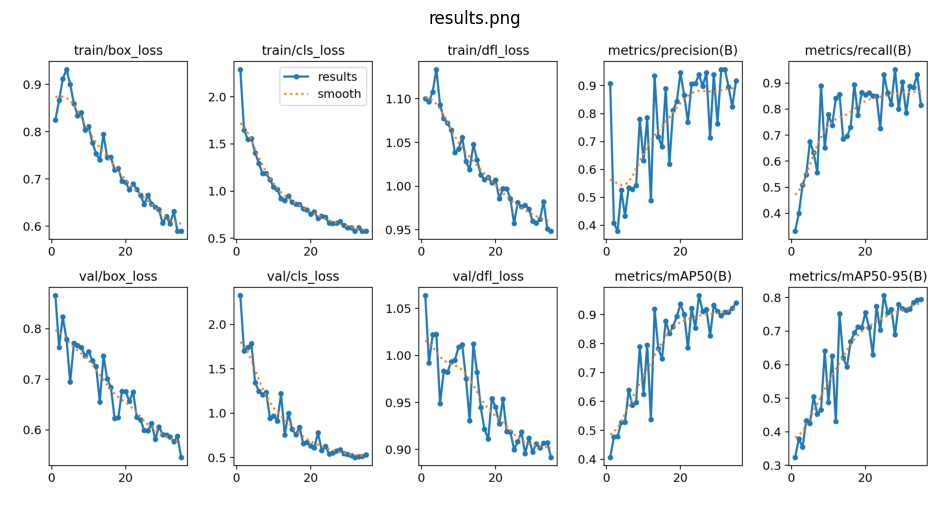

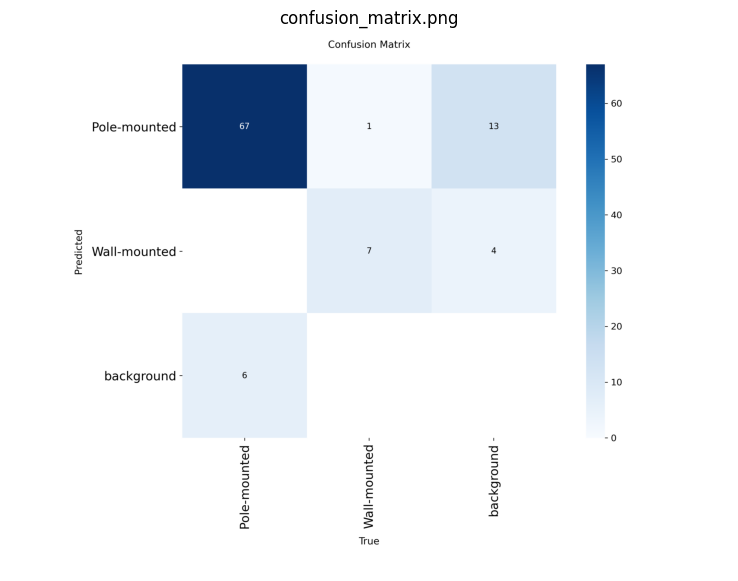

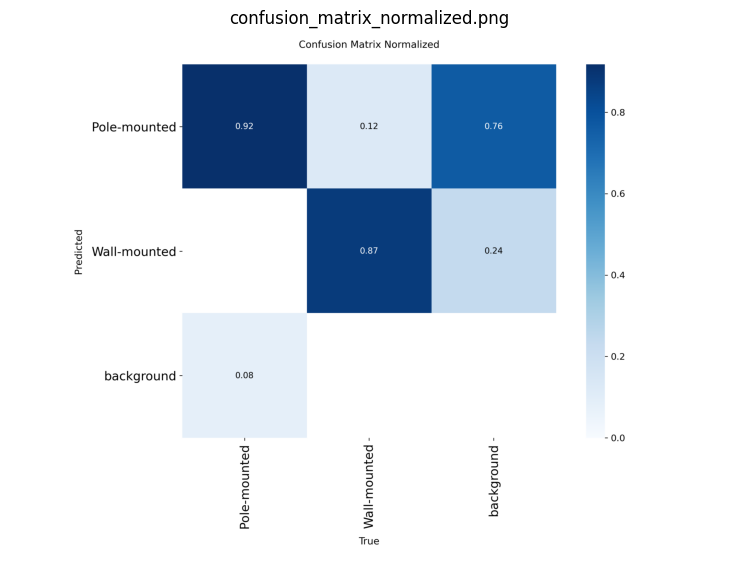

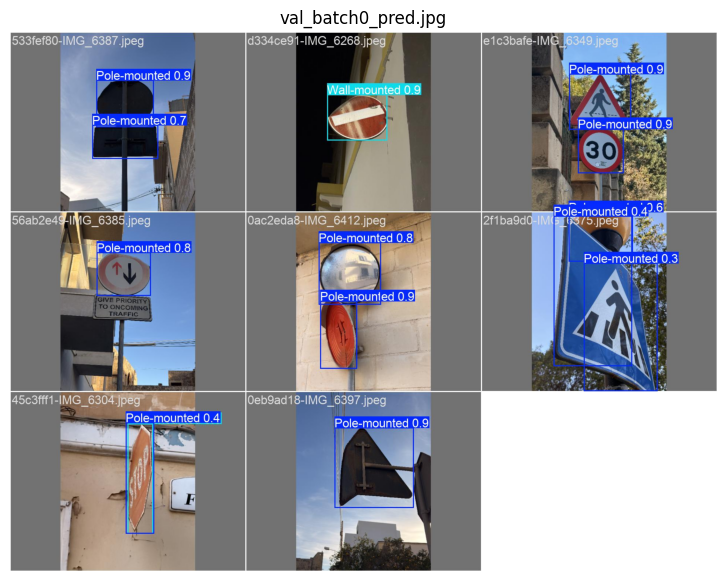

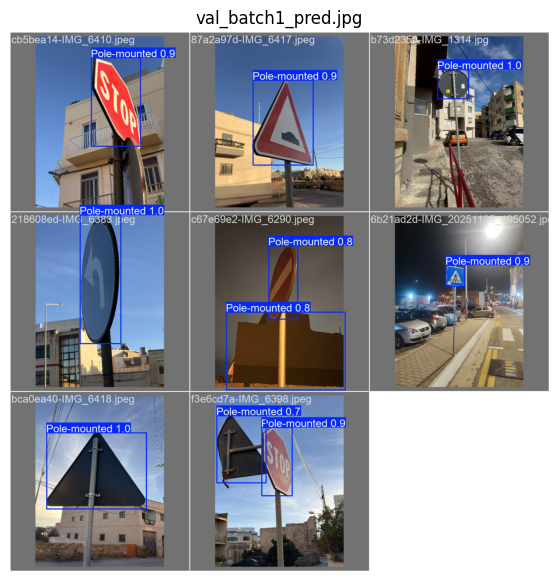

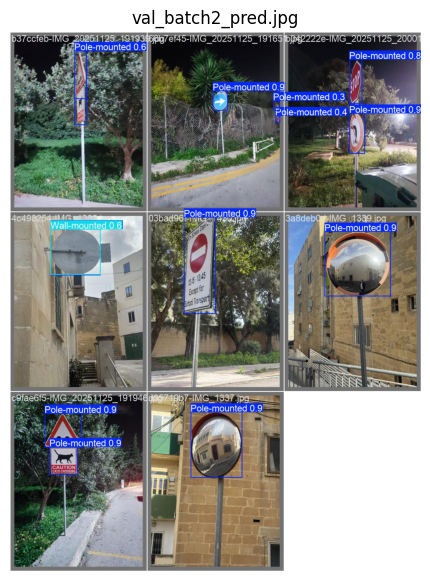

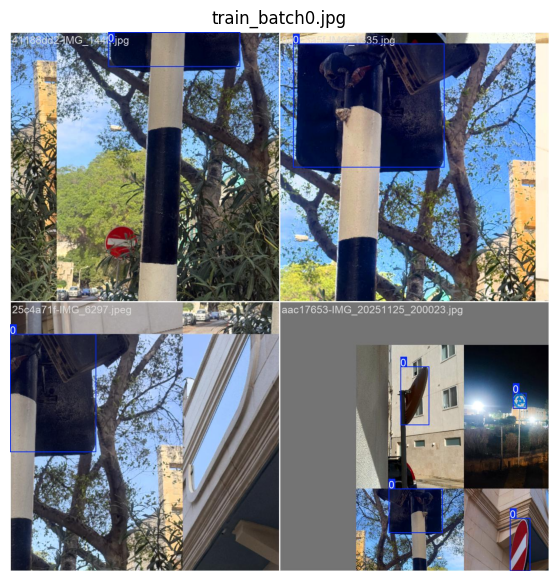

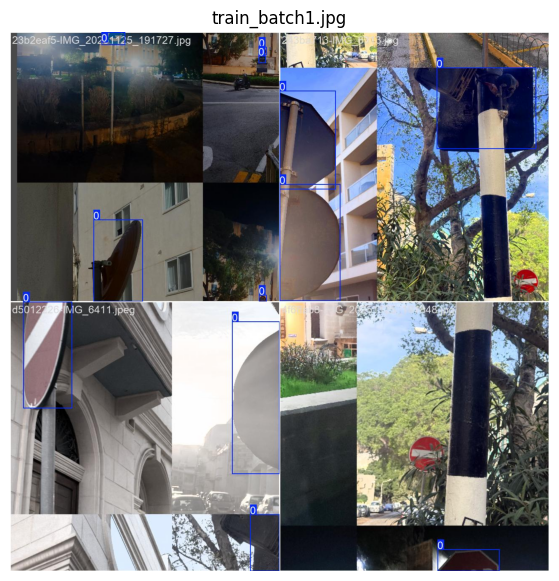

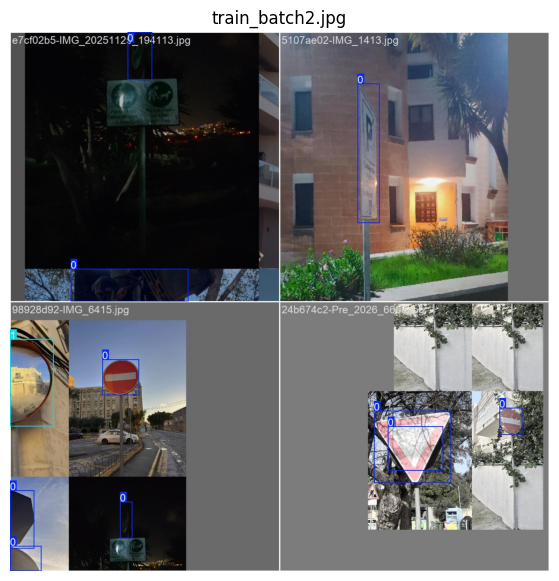

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

possibleImages = [
    "results.png",
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "val_batch0_pred.jpg",
    "val_batch1_pred.jpg",
    "val_batch2_pred.jpg",
    "train_batch0.jpg",
    "train_batch1.jpg",
    "train_batch2.jpg",
]

found = []
for name in possibleImages:
    p = runDir / name
    if p.exists():
        found.append(p)

print("Found images:", len(found))
for p in found:
    print(" -", p.name)

for p in found:
    img = Image.open(p)
    plt.figure(figsize=(12, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.title(p.name)
    plt.show()
